# Convolutional neural network for artwork recognition

## Input dataset processing

In [ ]:
import cv2, math, os, pickle, sys
import numpy as np
import pandas as pd
import seaborn as sn

%tensorflow_version 2.x
import tensorflow as tf

from google.colab import drive
# cv2_imshow is needed since cv2.imshow crashes jupyter notebooks
from google.colab.patches import cv2_imshow

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 120

from pathlib import Path

from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, LeakyReLU
from tensorflow.keras.layers import Conv2D, Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
# from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers.normalization import BatchNormalization
# from tensorflow.keras.layers.advanced_activations import 

from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# mount GDrive 
drive.mount("/content/drive", force_remount=True)
# add directory to path, so we can import the external python script for extracting frames
# sys.path.insert(0, "/content/drive/My Drive/Colab Notebooks/Modern_Art_CNN")

base_dir = Path("/content/drive/My Drive/Colab Notebooks/Modern_Art_CNN")
files_dir = base_dir / "contemporary_art_video_files"

Mounted at /content/drive


In [ ]:
# install required dependency
!pip install scikit-video

     |████████████████████████████████| 2.3MB 2.7MB/s 


In [ ]:
# import extenal video processing script
# from video_processing import video_processing

In [ ]:
import pickle
import skvideo.io


def get_video_rotation(video_path: str):
    """ Reads video rotation from video metadata.

    :param video_path: path to the video file
    :return: rotation of video in int degrees (e.g. 90, 180)
    :raises AssertionError if rotation is not available, files doesn't exist, or file doesn't have metadata
    """
    metadata = skvideo.io.ffprobe(video_path)
    for tags in metadata["video"]["tag"]:
        # we get OrderedDicts here
        if tags["@key"] == "rotate":
            return int(tags['@value'])
    else:
        raise AssertionError(f"Couldn't get rotation for {video_path}, either file doesn't exist, does not contain "
                             f"metadata, or rotation is not included in its metadata.")


def extract_video_frames(video_path: Path, save_as_files: bool = False):
    """ Extracts all frames from the provided video, and optionally saves them as individual images in a directory with
    the same name as the video.

    :param video_path: path to the video file
    :param save_as_files: whether to save extracted frames as individual image files
    :return: list of extracted frames
    """
    frame_dest = ""
    if save_as_files:
        # create frame destination dir and make sure it exists
        frame_dest = video_path.parent / video_path.stem
        frame_dest.mkdir(exist_ok=True)

    video_rotation = 0
    try:
        video_rotation = get_video_rotation(str(video_path))
    except AssertionError as e:
        print(e)

    count = 0

    vidcap = cv2.VideoCapture(str(video_path))
    success, frame = vidcap.read()

    all_frames = []

    while success:
        if count % 5 == 0:  # only save 1/5 of the frames 
            if video_rotation != 0:
                frame = rotate_frame(frame, video_rotation)

            frame = resize(frame)

            if save_as_files:
                cv2.imwrite(str(frame_dest / f"{video_path.stem}_{count}.jpg"), frame)

            all_frames.append(np.copy(frame))

        success, frame = vidcap.read()
        count += 1

    return all_frames


def rotate_frame(frame: np.ndarray, degrees: int):
    """ Rotates the provided frame 90, 180, or 270 degrees; any other value of degrees is ignored, and the original
    frame is returned un-rotated.

    :param frame: frame to be rotated
    :param degrees: degrees of rotation, must be either 90, 180, or 270, any other values are ignored
    :return: the rotated frame
    """
    if degrees == 90:
        return cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    elif degrees == 180:
        return cv2.rotate(frame, cv2.ROTATE_180)
    elif degrees == 270:
        return cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        return frame


def resize(frame: np.ndarray, target_dim: int = 224):
    """ Resizes the provided frame to a square with the provided dimension as its sides.

    :param frame: frame to be resized
    :param target_dim: the required side length of the resized frame (optional)
    :return: the resized frame
    """
    return cv2.resize(frame, (target_dim, target_dim), interpolation=cv2.INTER_AREA)


def video_processing(video_files_dir: Path):
    dataset = pd.read_csv(video_files_dir / "description_export.csv")

    # dict with all artwork IDs, as well as a corresponding numerical value
    artwork_dict = {artwork_id: i for i, artwork_id in enumerate(sorted(dataset["id"].unique()))}

    photos, labels = [], []
    t = tqdm(total=dataset.shape[0])
    total_frames = 0

    # process all video files
    for i in range(dataset.shape[0]):
        video_file_row = dataset.iloc[i]

        t.set_postfix_str(f"Processing file {video_file_row['file']} (total frames for far: {total_frames})")

        video_frames = extract_video_frames(video_files_dir / video_file_row["file"])

        frame_labels = [video_file_row["id"]] * len(video_frames)

        photos.extend(video_frames)
        labels.extend(frame_labels)

        total_frames += len(video_frames)
        t.update()

    t.close()

    # return results as a single dict
    return {"photos": photos, "labels": labels}

In [ ]:
# process and save exported frames
# processed = video_processing(files_dir)
# with open(files_dir / "processed", "wb+") as f:
#     pickle.dump(processed, f)

Import and process annotations .csv file.


In [ ]:
dataset = pd.read_csv(files_dir / "description_export.csv")
artwork_dict = {artwork_id: i for i, artwork_id in enumerate(sorted(dataset["id"].unique()))}
num_classes = len(artwork_dict)
class_list = artwork_dict.keys()
print(artwork_dict)
print(class_list)

{'bargilly_andis_secession': 0, 'chrysochos_andreas_autumn': 1, 'chrysochos_andreas_game_of_shapes': 2, 'chrysochos_andreas_throne_ii': 3, 'hadjida_vera_ground_plan': 4, 'hadjida_vera_untitled': 5, 'kouroussis_nicos_untitled': 6, 'ladommatos_andreas_ascent': 7, 'phinikarides_michael_armament': 8, 'sfikas_george_2-3': 9, 'votsis_stelios_presence': 10, 'votsis_stelios_the_cyclist': 11, 'votsis_stelios_untitled': 12}
dict_keys(['bargilly_andis_secession', 'chrysochos_andreas_autumn', 'chrysochos_andreas_game_of_shapes', 'chrysochos_andreas_throne_ii', 'hadjida_vera_ground_plan', 'hadjida_vera_untitled', 'kouroussis_nicos_untitled', 'ladommatos_andreas_ascent', 'phinikarides_michael_armament', 'sfikas_george_2-3', 'votsis_stelios_presence', 'votsis_stelios_the_cyclist', 'votsis_stelios_untitled'])


## Create and train CNN

Function that splits the input data into train, validation, and test subsets.


In [ ]:
def split_data(file_path):
    # read data
    with open(file_path, "rb") as f:
        f.seek(0)
        data = pickle.load(f)

    # infer image resolution (assumes square images!)
    img_dim = data["photos"][0].shape[0]

    # split data to images and labels
    data_x = np.array(data["photos"])
    print(data["labels"])
    data_y = np.array([artwork_dict[i] for i in data["labels"]])
    # data_y = np.array(data["labels"])
    print(data_y)

    print(data_x.shape, data_y.shape)

    # split to training and testing subsets
    train_X, test_X, train_Y, test_Y = train_test_split(data_x, data_y, 
                                                        test_size=0.2, 
                                                        random_state=0)

    # reshape data to 2D arrays
    # train_X = train_X.reshape(-1, img_dim, img_dim, z)
    # test_X = test_X.reshape(-1, img_dim, img_dim, z)

    # convert pixel values to 0-1 scale
    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    train_X = train_X / 255.
    test_X = test_X / 255.

    # change the labels from categorical to one-hot encoding
    train_Y_one_hot = to_categorical(train_Y)
    test_Y_one_hot = to_categorical(test_Y)

    # split train data again to create validation subset
    train_X,valid_X,train_label,valid_label = train_test_split(
        train_X, train_Y_one_hot, test_size=0.2, random_state=0)
    
    # d = CnnData(train_X=train_X, valid_X=valid_X, train_label=train_label,
    #             valid_label=valid_label, test_X=test_X, test_Y=test_Y,
    #             test_Y_one_hot=test_Y_one_hot, img_dim=img_dim)

    # package results in dictionary
    res = {"trX": train_X,"valX": valid_X,
            "trLab": train_label, "valLab": valid_label, 
            "tesX": test_X, "tesYhot": test_Y_one_hot, "tesY": test_Y,
            "img_dim": img_dim}
    
    return res

Function to create and compile the ConvNet model.

In [ ]:
# NOT USED for modern art recognition models, see VGG19 below

def create_conv_net_model(img_dim, RGB=True):
    # dimension of photo depending if RGB or grayscale  
    z = 3 if RGB else 1

    # set up convNet model
    # configuration of the model from this tutorial:
    # https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',
                        padding='same',input_shape=(img_dim,img_dim,z)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2),padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))                  
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))           
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    # compile model
    model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=['accuracy'])
    
    return model

In [ ]:
def create_VGG19_CNN(img_dim, RGB=True):
    img_dim = 224  # must always be 224 for VGG19
    
    z = 3 if RGB else 1  # dimension of photo depending if RGB or grayscale

    vggModel = VGG19(include_top=False, weights="imagenet", 
                     input_tensor=Input(shape=(img_dim, img_dim, z)))

    outputs = vggModel.output
    outputs = Flatten(name="flatten")(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(num_classes, activation="softmax")(outputs)

    model = Model(inputs=vggModel.input, outputs=outputs)

    for layer in vggModel.layers:
        layer.trainable = False

    model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=['accuracy'])
    
    return model

Function that trains and evaluates the network.

In [ ]:
def train_CNN(target_size, epochs=50, RGB=True, batch_size=64, verbose=1, 
              convert_to_TFlite=True, show_summary=True, VGG19=True):
    
    # if using VGG19, target_size must be 224
    if VGG19: target_size = 224

    # create model name
    model_name = f"cnn{target_size}" 
    if RGB: model_name += "RGB"
    else: model_name += "grayscale"
    if VGG19: model_name += "_VGG19"

    # input_data_file = p_join(base_dir, model_name, f"{model_name}_data")

    # dir structure for created files: 
        # base_dir/model_name/model_name_data.csv
        # base_dir/model_name/saved_model
        # base_dir/model_name/tflite/model_name.tflite
        # base_dir/model_name/tflite/model_name_labels.txt

    # if not input_data_file.is_file() or force_photo_reprocessing:
    #     # process photos
    #     print("Processing photos to provided specifications...")
    #     process_photos(input_data_file, target_size, RGB=RGB)
    #     print("Done!")
    # else:
    #     # skip processing, already processed file exists
    #     print("Photos already processed, skipping reprosessing.")

    # load pickled file
    # with open(files_dir / "processed", "rb") as f:
    #     f.seek(0)
    #     input_data_file = pickle.load(f)

    # split dataset
    print("Splitting dataset...", end=" ", flush=True)
    data = split_data(files_dir / "processed")
    print("Done!", flush=True)

    # create and train CNN
    print("Training neural network...")
    if VGG19:
        model = create_VGG19_CNN(target_size, RGB=RGB)

        train_aug = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True)
        model_train_info = model.fit(train_aug.flow(data["trX"], data["trLab"], batch_size),
                                     validation_data=(data["valX"], data["valLab"]),
                                     epochs=epochs)
    else:
        model = create_conv_net_model(target_size, RGB=RGB)
        model_train_info = model.fit(data["trX"], data["trLab"], batch_size, epochs,
                                        verbose, validation_data=(data["valX"],
                                                                data["valLab"]))
    print("Training complete.")

    # evaluate model
    print("Evaluating neural network...", end=" ", flush=True)
    test_eval = model.evaluate(data["tesX"], data["tesYhot"], verbose=1)

    # get training info
    accuracy = model_train_info.history['accuracy']
    val_accuracy = model_train_info.history['val_accuracy']
    loss = model_train_info.history['loss']
    val_loss = model_train_info.history['val_loss']

    # make predictions
    predicted_classes = model.predict(data["tesX"])
    predicted_classes = np.argmax(np.round(predicted_classes), axis=1)

    # create classification report
    target_names = class_list
    report = classification_report(data["tesY"], predicted_classes, 
                            target_names=target_names, output_dict=True)
    report = pd.DataFrame(report)

    # create confusion matrix
    cm = confusion_matrix(data["tesY"], predicted_classes)
    df_cm = pd.DataFrame(cm, class_list, class_list)

    # package results 
    res = {"test_eval": test_eval, "accuracy": accuracy, 
           "val_accuracy": val_accuracy, "loss": loss, "val_loss": val_loss,
           "predicted_classes": predicted_classes, "test_Y": data["tesY"], 
           "test_X": data["tesX"], "confusion_matrix": df_cm, "report": report,
           "model": model}

    print("Done!", flush=True)

    # save model
    saved_model_path = Path(base_dir, model_name, "saved_model")
    model.save(saved_model_path)

    # Convert model to tflite
    if convert_to_TFlite:
        print("Converting neural network to TFLite...", end=" ", flush=True)

        # first convert to normal tflite
        converter = tf.lite.TFLiteConverter.from_saved_model(str(saved_model_path))
        tflite_model = converter.convert()

        # second convert to quantized tflite
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_quant_model = converter.convert()

        tflite_dir = Path(base_dir) / model_name / "tflite"
        tflite_dir.mkdir(parents=True, exist_ok=True)
        
        with tf.io.gfile.GFile(str(tflite_dir / f"{model_name}.tflite"), "wb") as f:
            f.write(tflite_model)

        with tf.io.gfile.GFile(str(tflite_dir / f"{model_name}_quant.tflite"), "wb") as f:
            f.write(tflite_quant_model)

        # save txt file with labels, ready for use in mobile device
        labels_file = Path(tflite_dir, f"{model_name}_labels.txt")

        # write to file
        with open(labels_file, "w+") as f:
            for label in list(class_list):
                f.write(label + "\n")
        print("Done!", flush=True)

    # show results
    if show_summary:
        print('Test loss:', test_eval[0])
        print('Test accuracy:', test_eval[1])

    return res

In [ ]:
cnn224RGB_VGG19 = train_CNN(224, epochs=20, VGG19=True)

Splitting dataset... ['bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession', 'bargilly_andis_secession'

## Results

### Summary

In [ ]:
from IPython.display import HTML, display
import tabulate
pd.options.display.float_format = '{:,.3f}'.format
print( "Test accuracy:", cnn224RGB_VGG19["test_eval"][1], "\n\nTest loss:", cnn64["test_eval"][0], "\n")
display(HTML(cnn224RGB_VGG19["report"].to_html()))

Test accuracy: 1.0 

Test loss: 0.0003176155732944608 



,bargilly_andis_secession,chrysochos_andreas_autumn,chrysochos_andreas_game_of_shapes,chrysochos_andreas_throne_ii,hadjida_vera_ground_plan,hadjida_vera_untitled,kouroussis_nicos_untitled,ladommatos_andreas_ascent,phinikarides_michael_armament,sfikas_george_2-3,votsis_stelios_presence,votsis_stelios_the_cyclist,votsis_stelios_untitled,accuracy,macro avg,weighted avg
precision,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
recall,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
f1-score,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
support,57.000,56.000,52.000,53.000,73.000,56.000,46.000,71.000,51.000,56.000,52.000,48.000,61.000,1.000,732.000,732.000


### Training history

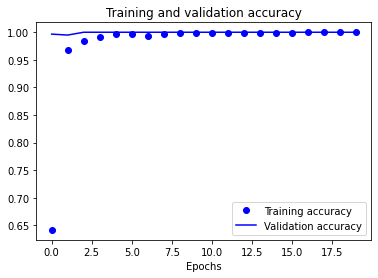

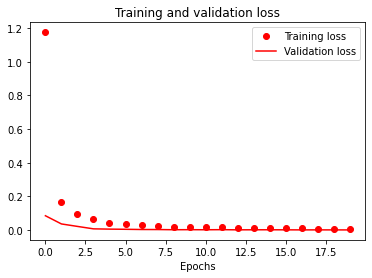

In [ ]:
epochs = 20
ep = range(epochs)
plt.plot(ep, cnn224RGB_VGG19["accuracy"], "bo",  label='Training accuracy')
plt.plot(ep, cnn224RGB_VGG19["val_accuracy"], "b",  label='Validation accuracy')
plt.xlabel("Epochs")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(ep, cnn224RGB_VGG19["loss"], "bo", label='Training loss', color ="red")
plt.plot(ep, cnn224RGB_VGG19["val_loss"], "b", label='Validation loss', color ="red")
plt.xlabel("Epochs")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Confusion matrix

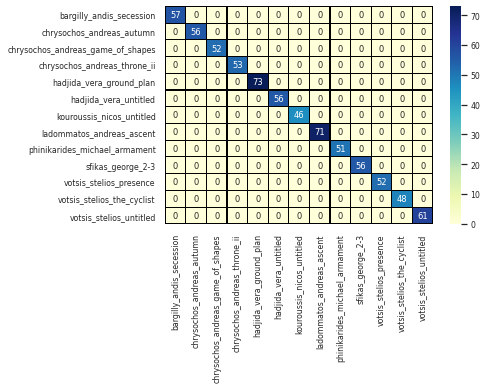

In [ ]:
cm = confusion_matrix(cnn224RGB_VGG19["test_Y"], cnn224RGB_VGG19["predicted_classes"])
df_cm = pd.DataFrame(cm, class_list, class_list)
sn.set(font_scale=.7)
sn.heatmap(df_cm, vmin=0, annot=True, 
            cmap="YlGnBu", fmt="d", 
            linewidths=0.1, linecolor="black")
plt.show()

### Prediction examples

In [ ]:
# target_size = 224
# class_dict_rev = {v:k for k, v in artwork_dict.items()}
# correct = np.where(cnn224RGB_VGG19["predicted_classes"]==cnn224RGB_VGG19["test_Y"])[0]
# print(f"Found {len(correct)} correct labels")
# for i, correct in enumerate(correct[:9]):
#   pred, actual = class_dict_rev[cnn224RGB_VGG19['predicted_classes'][correct]], class_dict_rev[cnn224RGB_VGG19['test_Y'][correct]]
#   plt.subplot(3,3,i+1)
#   plt.imshow(cnn224RGB_VGG19["test_X"][correct].reshape(target_size, target_size, 3), cmap='gray', interpolation='none')
#   plt.grid(None)
#   plt.title(f"pred: {pred}, actual: {actual}")
#   plt.tight_layout()

In [ ]:
# incorrect = np.where(cnn64["predicted_classes"]!=cnn64["test_Y"])[0]
# print(f"Found {len(incorrect)} incorrect labels")
# for i, incorrect in enumerate(incorrect[:9]):
#   pred, actual = class_dict_rev[cnn64['predicted_classes'][incorrect]], class_dict_rev[cnn64['test_Y'][incorrect]]
#   plt.subplot(3,3,i+1)
#   plt.imshow(cnn64["test_X"][incorrect].reshape(target_size, target_size), cmap='gray', interpolation='none')
#   plt.grid(None)
#   plt.title(f"pred: {pred}, actual: {actual}")
#   plt.tight_layout()

## Testing (NOT UPDATED FOR MODERN ART)

In [ ]:
interpreter = tf.lite.Interpreter(model_path=os.path.join(base_dir,"saved_models","cnn64RGB.tflite"))
interpreter.allocate_tensors()

In [ ]:
with open(fp, "r") as f:
    processed = pd.read_csv(f)

processed.shape

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the converted tflite model with original dataset
predictions=[]
for i in range(1,processed.shape[0]):
    input_data = processed.iloc[i-1:i,:-1].to_numpy().reshape(-1,64,64,3).astype("float32")/255.
    actual = processed.iloc[i-1:i,-1:].to_numpy()[0]

    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    predictions.append(output_data.argmax() == actual)
    # print(i, "predicted", output_data.argmax(), "actual", actual)

print("Correctly identified photos:",f"{sum(predictions)[0]}/{processed.shape[0]}", 
      f"({sum(predictions)[0]/processed.shape[0]:.2%})")

In [ ]:
# test with original photos that have only 1 label each, without cropping

one_label = dataset['photo'].value_counts()[lambda x: x==1].index.tolist()

photos_1_label = dataset[dataset['photo'].isin(one_label)]
photos_1_label.shape

predictions_1_label=[]

for i, row in photos_1_label.iterrows():
    # get photo
    photo_array = cv2.imread(os.path.join(photo_dir, row["photo"]))

    # crop and resize
    photo_array = cv2.resize(photo_array, (64, 64), interpolation=cv2.INTER_AREA)

    input_data = photo_array.reshape(-1,64,64,3).astype("float32")/255.
    actual = class_dict[row["class"]]
    if i < 40:
        print(input_data)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    predictions_1_label.append(output_data.argmax() == actual)
    # print(i, "predicted", output_data.argmax(), "actual", actual)

print("Correctly identified photos:",f"{sum(predictions_1_label)}/{photos_1_label.shape[0]}", 
      f"({sum(predictions_1_label)/photos_1_label.shape[0]:.2%})")

In [ ]:
from glob import glob

for model in glob(os.path.join(base_dir,"saved_models","*.tflite"),recursive=True):
    interpreter = tf.lite.Interpreter(model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    print(os.path.split(model)[1],"\n", interpreter.get_input_details(),"\n",interpreter.get_output_details())

In [ ]:
pip install tflite-support